## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
from ipywidgets import interact, interactive, fixed
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import os.path
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from utils import build_distort_p, load_distort_p, get_perspective_transform, s_filter, sobel_filter, combine_binaries, draw_result
from showcase import show_calibration_result, show_perspective_transform_result, show_color_threshold_result, show_filtered_warped_image
from poly import fit_poly
from line import Line

In [3]:
DISTORT_P = 'distort.p'

is_show_calibration_result = True
is_show_perspective_transform_result = True
is_show_color_threshold_result = True
is_show_filtered_warped_image = True

## First, I'll compute the camera calibration using chessboard images

In [4]:
if not os.path.isfile(DISTORT_P):
    build_distort_p(DISTORT_P)

mtx, dist = load_distort_p(DISTORT_P)

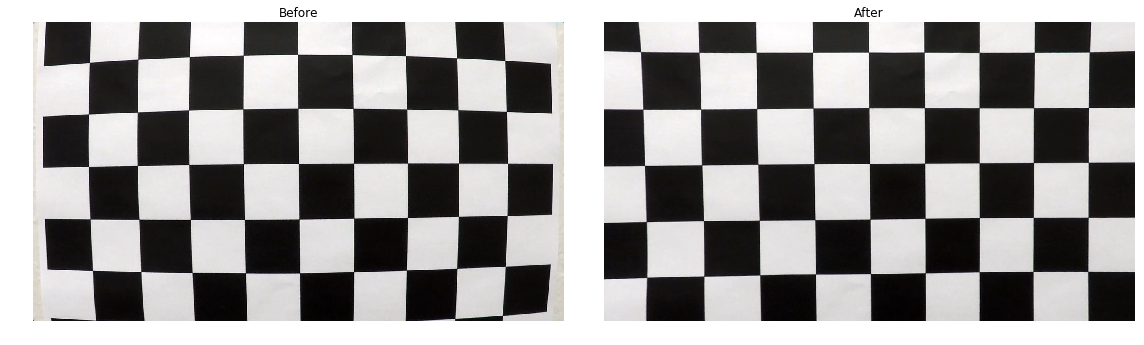

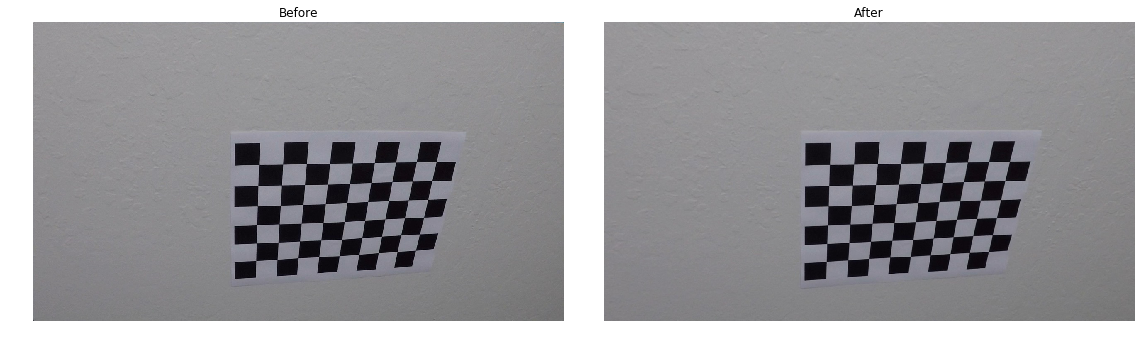

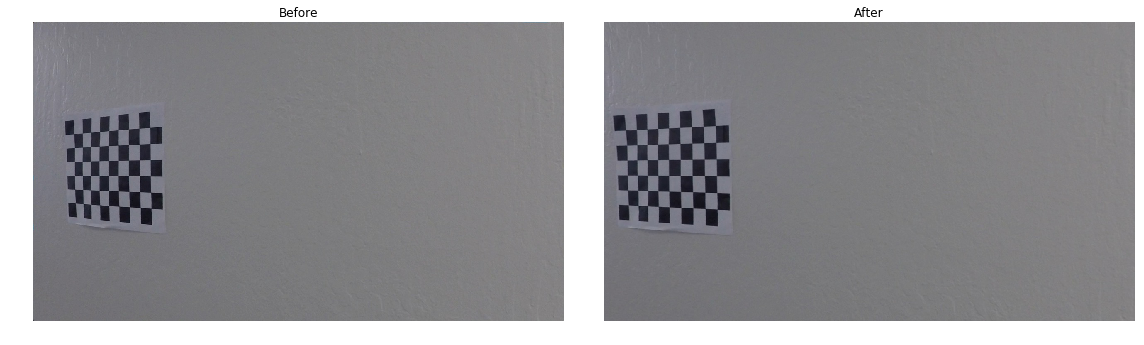

In [5]:
if is_show_calibration_result:
    show_calibration_result(mtx, dist)

## Decide the perspective tranform matrix

In [6]:
M, Minv = get_perspective_transform()

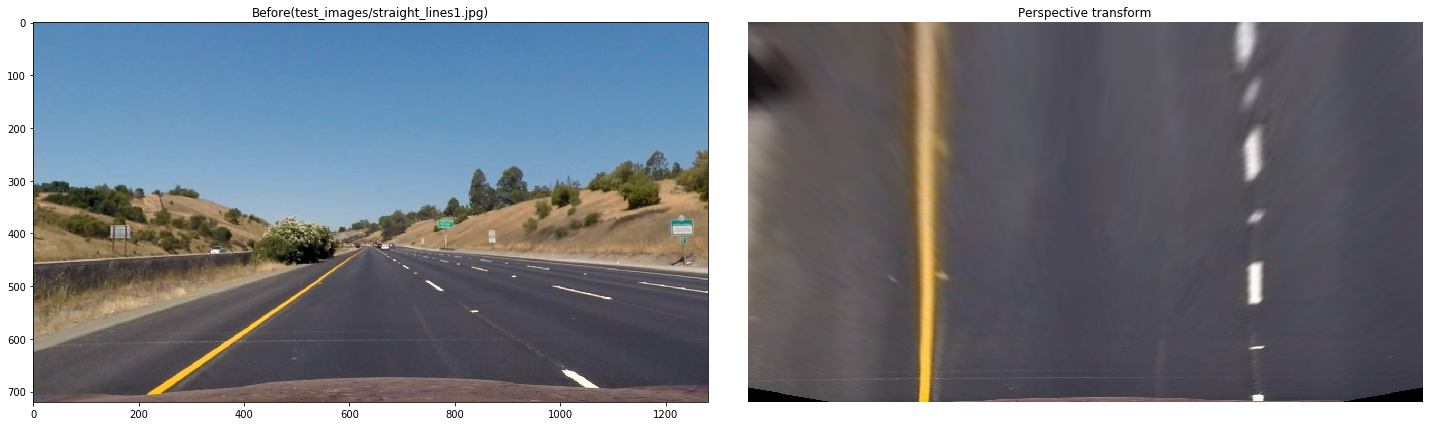

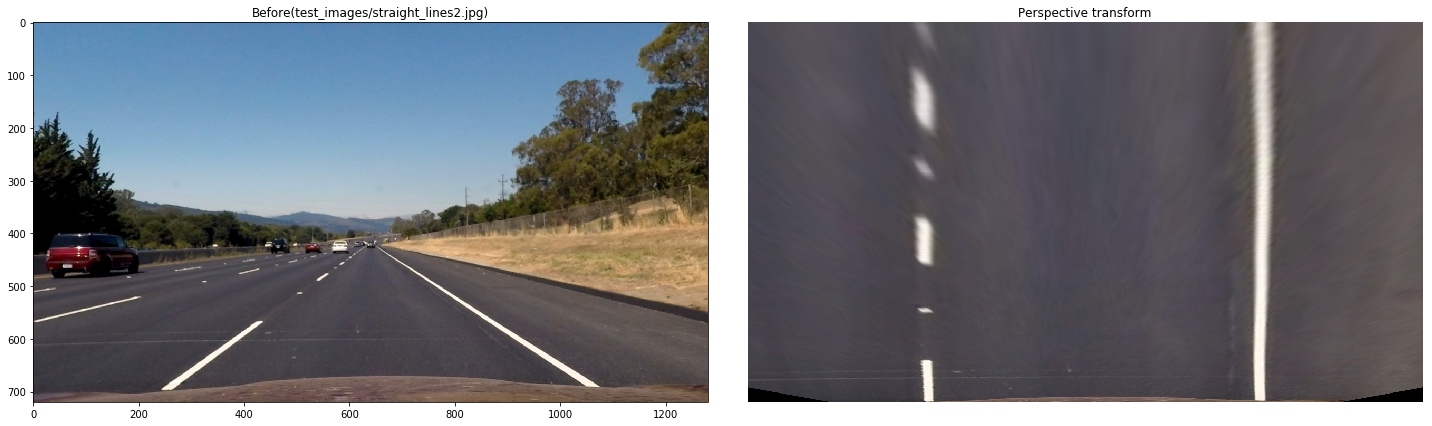

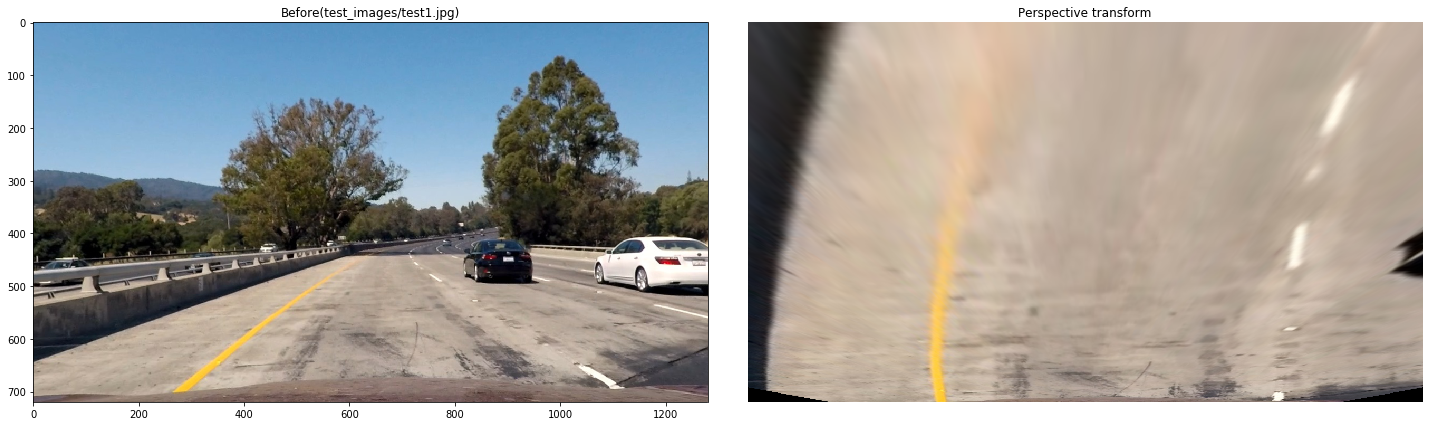

In [7]:
if is_show_perspective_transform_result:
    show_perspective_transform_result(mtx, dist, M)

## Use color transforms, gradients, etc., to create a thresholded binary image

1. Color space (Gray, HLS, YUV, HSV)
2. Sobel
3. Magnitude of the Gradient


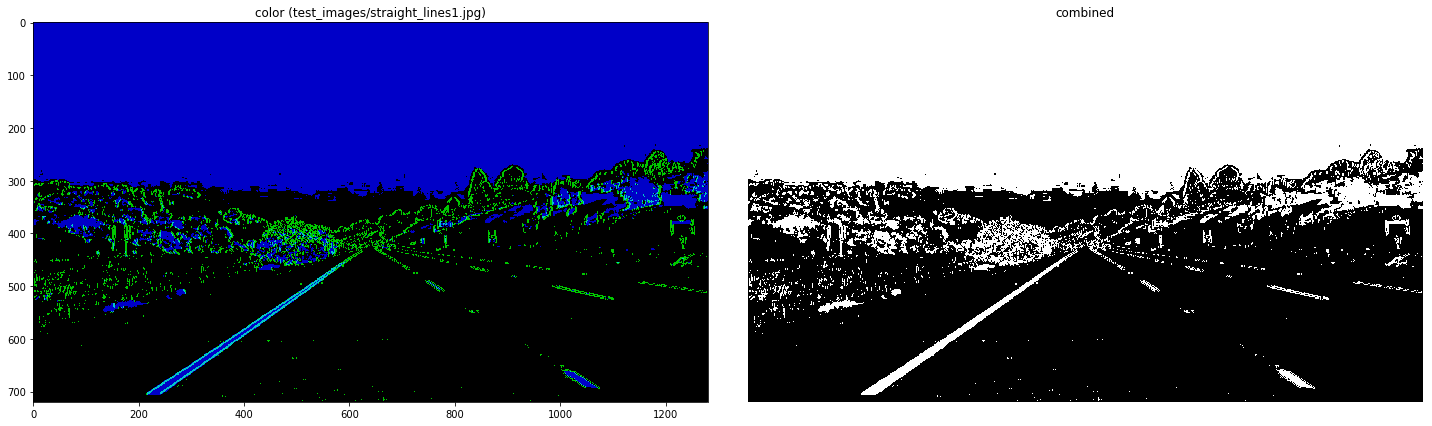

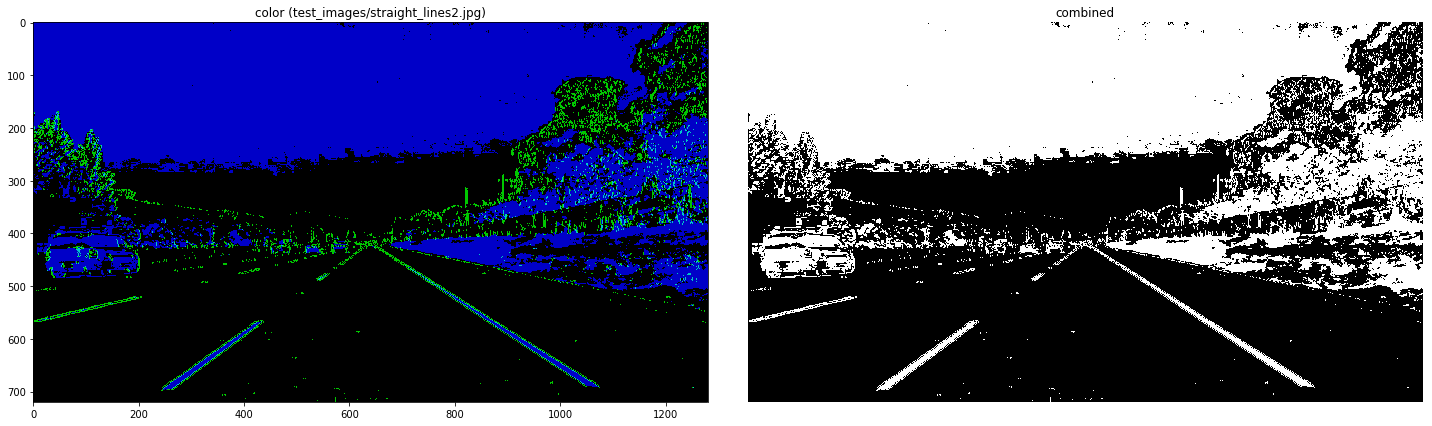

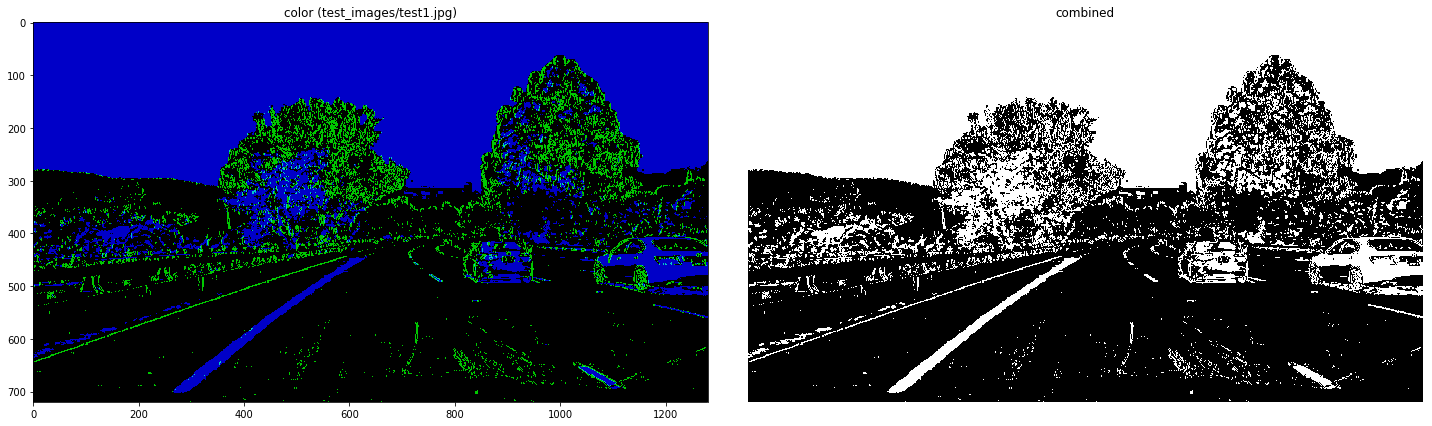

In [8]:
if is_show_color_threshold_result:
    show_color_threshold_result(mtx, dist, M)

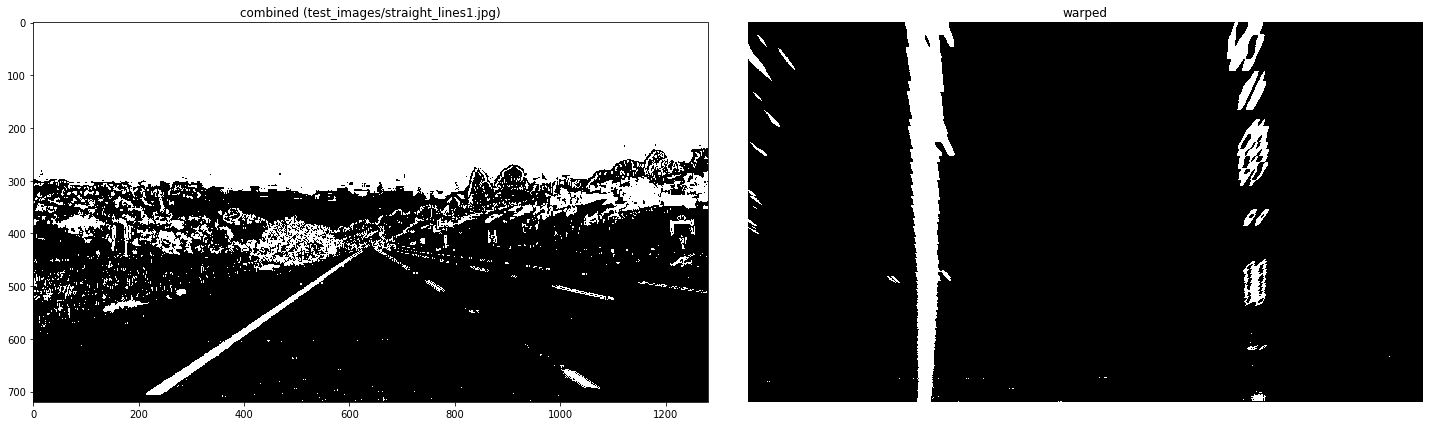

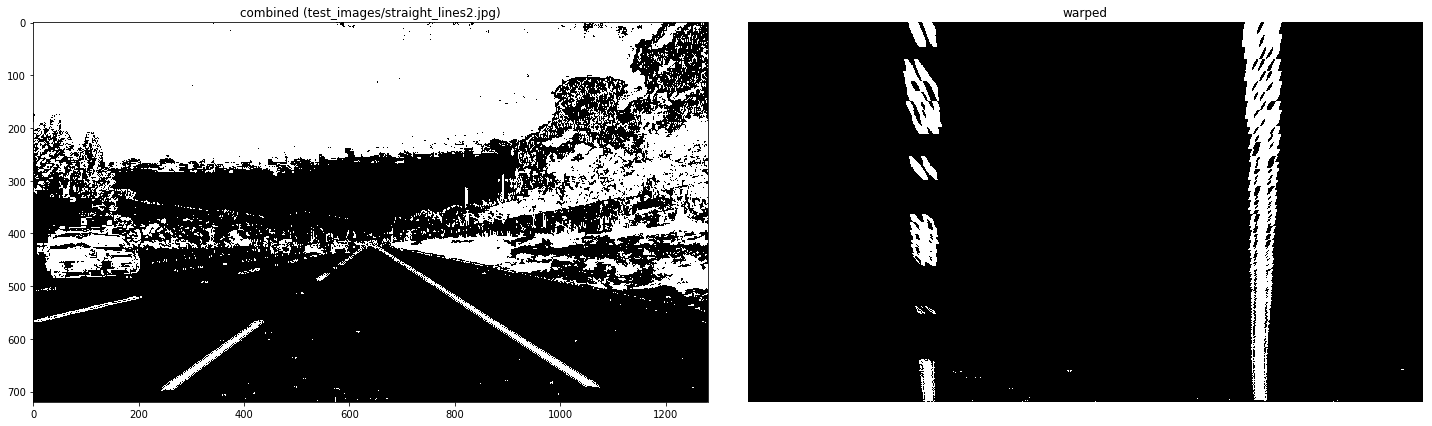

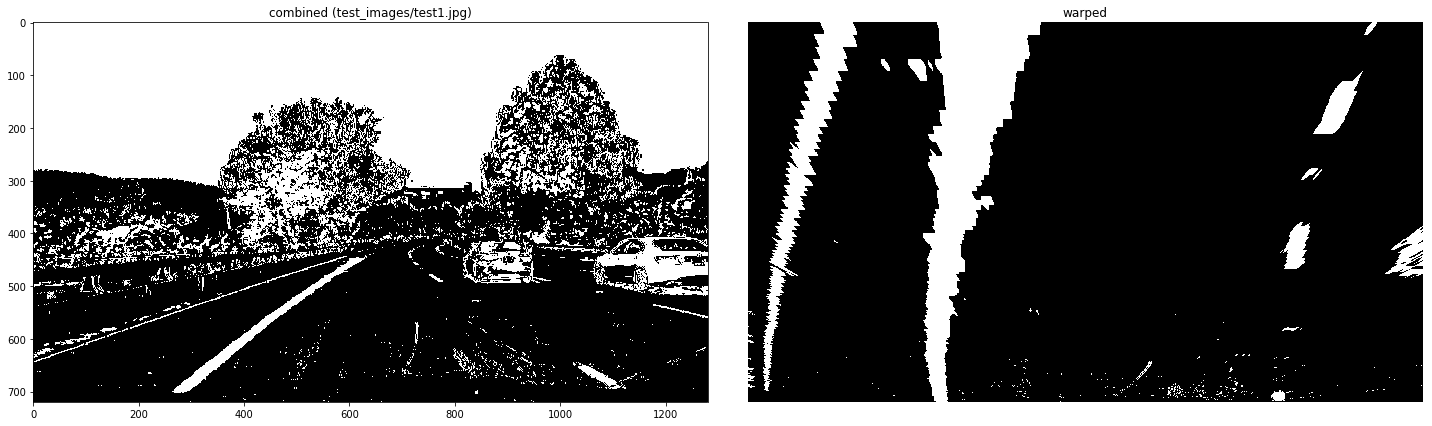

In [9]:
if is_show_filtered_warped_image:
    show_filtered_warped_image(mtx, dist, M)

## Test filters

In [10]:
lanelines = [Line(), Line()]

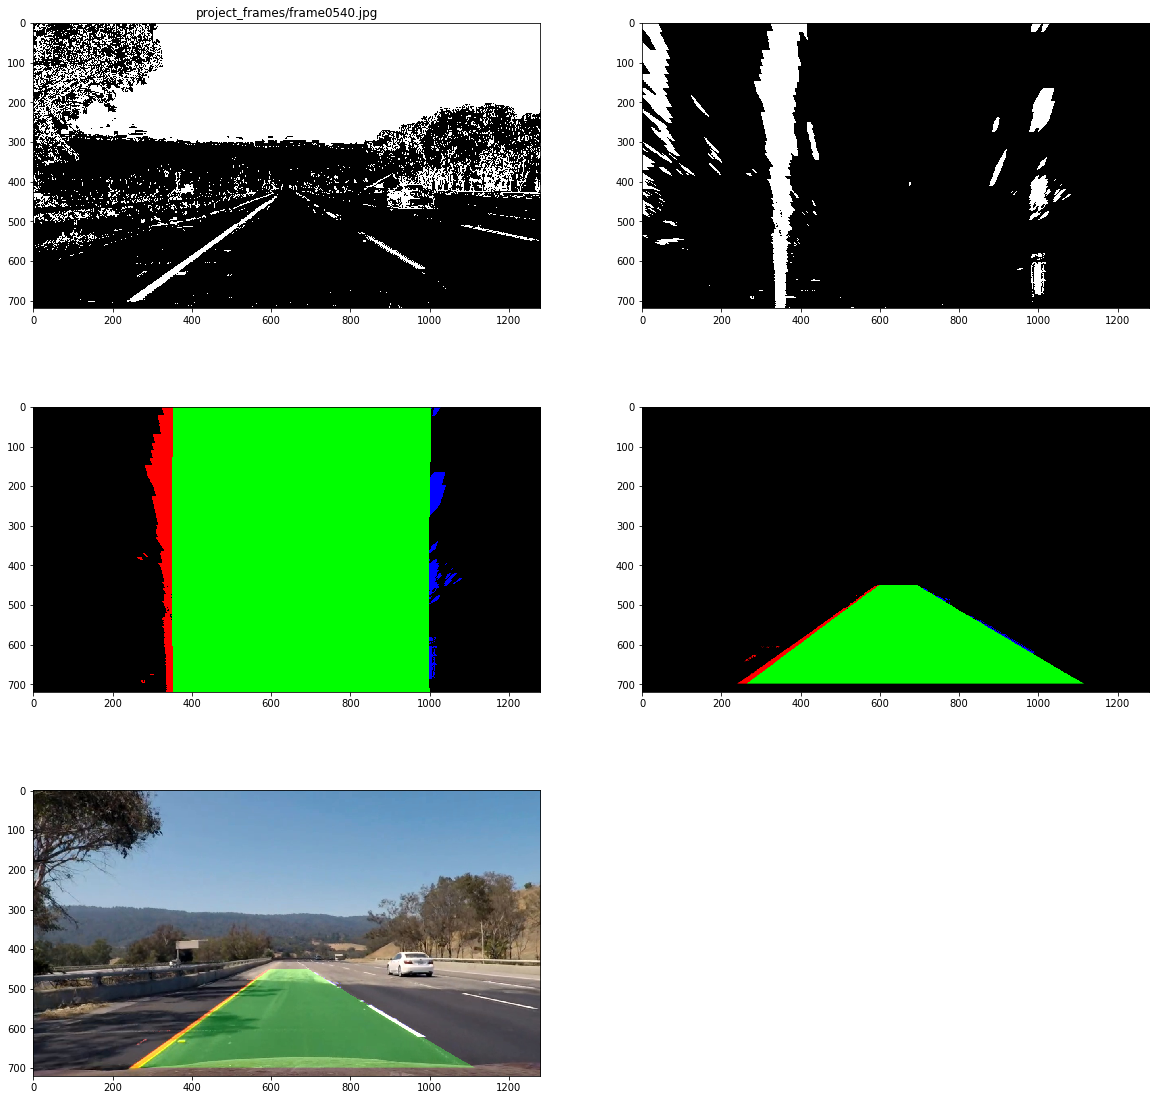

In [11]:
images = glob.glob('project_frames/frame054*.jpg')

for file in images:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    s_binary = s_filter(undist)
    sxbinary = sobel_filter(undist)
    combined_binary = combine_binaries(s_binary, sxbinary)

    binary_warped = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]), flags=cv2.INTER_LINEAR)
    color_warp = np.zeros_like(img)

    fit_poly(binary_warped, lanelines)
        
    # Coloring the warped image
    color_warp[lanelines[0].ally, lanelines[0].allx] = [255, 0, 0] # Left lane
    color_warp[lanelines[1].ally, lanelines[1].allx] = [0, 0, 255] # Right lane

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Recast the x and y points into usable format for cv2.fillPoly()
    
    pts_left = np.array([np.transpose(np.vstack([lanelines[0].recent_xfitted, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([lanelines[1].recent_xfitted, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Apply Minv to untransform the colored image
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    overlay_img = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(321)
    plt.imshow(combined_binary, cmap='gray')
    plt.title(file)
    plt.subplot(322)
    plt.imshow(binary_warped, cmap='gray')
    plt.subplot(323)
    plt.imshow(color_warp)
    plt.subplot(324)
    plt.imshow(newwarp)
    plt.subplot(325)
    plt.imshow(overlay_img)
    
    plt.show()

## Process video

In [12]:
import imageio
imageio.plugins.ffmpeg.download()

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
# Define global variables here
lanelines = [Line(), Line()]

In [15]:
def process_image(image):

    undist = cv2.undistort(image, mtx, dist, None, mtx)

    # Make lane lines obvious
    s_binary = s_filter(undist)
    sxbinary = sobel_filter(undist)
    combined_binary = combine_binaries(s_binary, sxbinary)

    # Perspective transform to bird view
    binary_warped = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]), flags=cv2.INTER_LINEAR)
    color_warp = np.zeros_like(img)

    # Get polynomial coefficients for left/right lanes
    fit_poly(binary_warped, lanelines)
        
    # Coloring the warped image
    color_warp[lanelines[0].ally, lanelines[0].allx] = [255, 0, 0] # Left lane
    color_warp[lanelines[1].ally, lanelines[1].allx] = [0, 0, 255] # Right lane

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Recast the x and y points into usable format for cv2.fillPoly()    
    pts_left = np.array([np.transpose(np.vstack([lanelines[0].recent_xfitted, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([lanelines[1].recent_xfitted, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Apply Minv to untransform the colored image
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Merge two images
    overlay_img = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # Add text info
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(overlay_img,'Radius of Curvature = %d(m)' % lanelines[0].radius_of_curvature,(20,60), font, 2, (255,255,255),2,cv2.LINE_AA)
    mid = (lanelines[0].line_base_pos + lanelines[1].line_base_pos)/2.0
    if lanelines[0].line_base_pos >= lanelines[1].line_base_pos:
        cv2.putText(overlay_img,'Vehicle is %2.2fm right of center' % (lanelines[0].line_base_pos-mid),(20,120), font, 2, (255,255,255),2,cv2.LINE_AA)
    else:
        cv2.putText(overlay_img,'Vehicle is %2.2fm left of center' % (lanelines[1].line_base_pos-mid),(20,120), font, 2, (255,255,255),2,cv2.LINE_AA)
    
    return overlay_img

In [16]:
cur_frame = 0
def save_image(image):
    global cur_frame
    if cur_frame % 12 == 0:
        img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite('frame%04d.jpg' % cur_frame, img)
    cur_frame += 1
    return image

In [17]:
output = 'output_images/output.mp4'
clip1 = VideoFileClip('project_video.mp4')
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/output.mp4
[MoviePy] Writing video output_images/output.mp4


100%|█████████▉| 1260/1261 [02:52<00:00,  7.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/output.mp4 

CPU times: user 3min 6s, sys: 26.9 s, total: 3min 33s
Wall time: 2min 53s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))